# Reduccion de dimensionalidad: caso de Estudio Penguins Palmer

![penguin-palmer.png](penguin-palmer.png)


### 🌟 **¿Qué es la reducción de dimensionalidad?**

Es una técnica que nos permite **resumir muchas variables en pocas** sin perder demasiada información.
Por ejemplo, si para estudiar un pingüino mides:

* Longitud del pico
* Profundidad del pico
* Longitud de la aleta
* Masa corporal
* Altura

… puede que todas estas medidas estén relacionadas entre sí. Entonces, en lugar de trabajar con 5 variables, puedes transformarlas y resumirlas en 2 nuevas variables (componentes principales) que explican casi toda la variación.

✅ **Beneficios según el texto:**

* Aumenta la eficiencia (menos columnas → menos cálculo).
* Menos almacenamiento.
* Elimina datos redundantes.
* Mejora la visualización y reduce ruido.

---

### 🐧 **Ejemplo con pingüinos**

En el dataset de Palmer Archipelago, cada pingüino tiene 7 variables numéricas.

#### **Pregunta:** 
¿Necesitamos las 7 para distinguir sus especies?

#### **Respuesta:** 
¡No! Usando PCA podemos proyectarlos en 2 dimensiones y, según el texto, esas dos nuevas variables explican un **92 % de la variabilidad total**.

---

### 🔎 **¿Qué es el PCA?**

El **Análisis de Componentes Principales (PCA)**:

* Busca **correlaciones** entre variables.
* Calcula **nuevos ejes (componentes)** que capturan la máxima variabilidad de los datos.
* Cada eje nuevo es una **combinación lineal de las variables originales** y no están correlacionados entre sí.

---

### 📌 **¿Qué pruebas estadísticas antes de PCA?**

Según el texto, debes asegurarte de que:

1. Los datos sean numéricos.
2. No haya valores faltantes (o imputarlos).
3. Estandarizar los datos (media 0 y varianza 1).

También es buena práctica:

* **Comprobar normalidad** de cada variable (ejemplo: Shapiro–Wilk o Kolmogórov-Smirnov).
* **Verificar valores atípicos** y tratarlos (boxplots, scatterplots).

---

### 📈 **¿Qué es la covarianza?**

Es una medida que nos dice cómo varían dos variables juntas:

* Positiva → aumentan juntas.
* Negativa → una sube mientras la otra baja.
* Cero → no hay relación.

👉 El PCA usa la **matriz de covarianza** para ver qué variables se mueven juntas y encontrar ejes nuevos.

---

### 🧭 **¿Qué son los autovalores y autovectores?**

* **Autovectores:** indican la **dirección** de los nuevos ejes (componentes principales).
* **Autovalores:** indican la **importancia** de cada eje (cuánta varianza explica cada uno).

En PCA:

1. Se calcula la matriz de covarianza.
2. Se obtienen sus autovectores y autovalores.
3. Se ordenan los autovalores de mayor a menor.
4. Se eligen los primeros `k` autovectores como nuevas dimensiones.



# 📚 Cargar librerías y datos  
# 🔄 Aplicar PCA (todas las componentes)  
# 📊 Mostrar cargas (loadings) y coordenadas (scores)  
# 📈 Scree plot + PVE acumulado  
# 🐧 Scatter PC1 vs PC2 diferenciando especie y sexo  

# 📦 Instalar librerías  

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from kneed import KneeLocator
import plotly.express as px


# 📚 Cargar librerías y datos  

Intentaremos utilizar la librería oficial **`palmerpenguins`** para cargar el conjunto de datos.
En caso de que esta librería no se encuentre instalada en el entorno, realizaremos un respaldo cargando el dataset desde el CSV incluido en **Seaborn**.

Para instalar la librería oficial, puedes ejecutar:

```bash
pip install palmerpenguins
```

De este modo aseguramos que, si la instalación está disponible, trabajaremos con la versión más completa y actualizada del dataset; y si no, tendremos un plan alternativo sin interrumpir el flujo de trabajo.



In [2]:
# Intentamos usar la librería *palmerpenguins* (oficial).
# Si no está instalada, hacemos fallback al CSV que aloja Seaborn.
try:
    from palmerpenguins import load_penguins  # => pip install palmerpenguins
    penguins = load_penguins()
except ModuleNotFoundError:
    import seaborn as sns                     # seaborn suele estar en Colab
    penguins = sns.load_dataset("penguins")

# 📐 Normalizar variables numéricas  

Requisitos previos antes de aplicar el PCA: 
- los datos deben ser valores numéricos;
- cualquier valor que falte en los datos debe eliminarse o imputarse; y
- los datos numéricos deben estar estandarizados para que las características sean comparables.

## 🚫 Manejo de datos nulos

In [3]:
# Eliminamos filas con valores NA para evitar errores de PCA.
penguins = penguins.dropna()

## 🔎 Revisar filas del DataFrame

### 🤯 Revisar primeras filas del DataFrame


In [4]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


### 📋 Revisar tipos de datos del DataFrame


In [5]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


## 🔢 Transformar datos categóricos a numéricos

Al inspeccionar el DataFrame observamos que contiene 7 columnas:

* **Variables numéricas:**
  `bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`
* **Variables categóricas (tipo `object`):**
  `species`, `island`, `sex`

El método **PCA** únicamente acepta valores numéricos, por lo que debemos transformar las variables categóricas relevantes en valores numéricos antes de aplicarlo.
En este caso, decidimos incluir también la información de especie y sexo, manteniendo un total de **6 variables** (4 numéricas originales + 2 columnas codificadas):

* `species_num`:

  * 0 = Adelie
  * 1 = Chinstrap
  * 2 = Gentoo

* `sex_num`:

  * 0 = Female
  * 1 = Male

Usamos **`LabelEncoder`** para estas transformaciones, ya que convierte cada variable categórica en **una sola columna numérica**, evitando el aumento de dimensiones que produciría un *one-hot encoding*.
La columna `island` se mantiene fuera de este análisis porque no la consideraremos como predictor en el PCA.


In [7]:
# --- Codificar species ---
le_species = LabelEncoder()
penguins["species_num"] = le_species.fit_transform(penguins["species"])
# --- Codificar sex (con cuidado: algunos registros pueden usar minúsculas) ---
le_sex = LabelEncoder()
penguins["sex_num"] = le_sex.fit_transform(penguins["sex"].str.title())
# --- Codificar Island ---
le_island = LabelEncoder()
penguins["island_num"] = le_island.fit_transform(penguins["island"].str.title())

# Verificamos resultado
print("\n=== Preview con variables codificadas ===")
print(penguins[["species", "species_num", "sex", "sex_num", "island", "island_num"]].head())


=== Preview con variables codificadas ===
  species  species_num     sex  sex_num     island  island_num
0  Adelie            0    Male        1  Torgersen           2
1  Adelie            0  Female        0  Torgersen           2
2  Adelie            0  Female        0  Torgersen           2
4  Adelie            0  Female        0  Torgersen           2
5  Adelie            0    Male        1  Torgersen           2


## 📏 Normalizar datos (escalado Z‑score)

### 🔹 1. Definir las columnas numéricas que se usarán en el PCA

In [ ]:

numeric_cols = [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
    "species_num",
    "sex_num",
    "island_num"
]

Aquí se seleccionan las **columnas numéricas** del dataset que serán usadas como entrada para el PCA.
Incluye tanto variables cuantitativas originales (longitudes y masa), como las **variables categóricas que fueron transformadas a números** (`species_num`, `sex_num`, `island_num`).

✅ Esto es importante porque el PCA solo trabaja con datos **numéricos y continuos**.

### 🔹 2. Crear el objeto StandardScaler

In [ ]:

scaler = StandardScaler()

Se crea un objeto del tipo `StandardScaler`, que pertenece a `sklearn.preprocessing`.
Este objeto servirá para **normalizar cada columna individualmente**, aplicando la fórmula del **Z‑score**:

$$
Z = \frac{X - \mu}{\sigma}
$$

Esto transforma cada columna para que tenga:

* **Media = 0**
* **Desviación estándar = 1**

⚠️ Esto es fundamental en PCA porque:

* PCA calcula la **varianza** y las **covarianzas** entre variables.
* Si las variables tienen escalas distintas (por ejemplo, gramos vs. milímetros), las de mayor escala **dominarán** la rotación de los ejes principales y sesgarán los resultados.

###  🔹 3. Ajustar y transformar los datos

In [10]:
X_scaled = scaler.fit_transform(penguins[numeric_cols])

Este paso tiene dos acciones:

* `.fit(...)`: calcula la **media** y la **desviación estándar** de cada columna.
* `.transform(...)`: aplica la transformación Z‑score a cada valor de cada columna.

📌 **Resultado**:

* `X_scaled` es un **nuevo arreglo NumPy**, donde todos los valores han sido estandarizados.
* Este array se utilizará como **entrada directa del PCA** en el siguiente paso.

### 🎯 **Objetivo de este bloque: Aplicar el Análisis de Componentes Principales (PCA)**

###  🔹 4. Crear el modelo PCA

In [12]:
pca = PCA()

Aquí estás creando un objeto del tipo `PCA()` desde la librería `sklearn.decomposition`.

* **No estás especificando `n_components`**, lo cual significa que el modelo calculará **todos los componentes principales posibles**, es decir:

$$
n_{\text{componentes}} = \min(n_{\text{muestras}}, n_{\text{variables}})
$$

✅ Esto es útil cuando quieres analizar **toda la estructura del espacio de varianza** antes de decidir con cuántas dimensiones quedarte.

### 🔹 5. Ajustar el modelo y transformar los datos

In [14]:
X_pca = pca.fit_transform(X_scaled)

Este paso realiza dos cosas:

1. **`fit(X_scaled)`**:
   Calcula los **autovectores y autovalores** de la **matriz de covarianza** de los datos normalizados.

   * Los **autovectores** determinan las **direcciones** (componentes principales).
   * Los **autovalores** determinan cuánta **varianza** explica cada componente.

2. **`transform(X_scaled)`**:
   Proyecta cada punto del conjunto de datos original en el nuevo espacio definido por los componentes principales.

📌 El resultado es `X_pca`, una **nueva matriz de características**, donde:

* Cada fila representa un pingüino.
* Cada columna representa un componente principal (PC1, PC2, PC3, etc.).
* Estas nuevas variables **no están correlacionadas entre sí** (son ortogonales) y capturan la **mayor variabilidad posible** de los datos.

### ✅ **¿Por qué se hace esto?**

Este paso es el corazón del PCA:

* Has transformado un conjunto de datos multivariable en un nuevo sistema de coordenadas rotado, donde **las primeras columnas (PC1, PC2...) explican la mayor parte de la información**.
* Más adelante, puedes decidir cuántas de esas columnas conservar (por ejemplo, las 2 primeras si explican más del 80% de la varianza).


### 🔹 6. Crear el DataFrame con las cargas

In [15]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(numeric_cols))],
    index=numeric_cols,
)

Este bloque:

* Construye un DataFrame llamado `loadings`.
* Usa como datos la matriz transpuesta `pca.components_.T`.
* Asigna como columnas `PC1`, `PC2`, ..., hasta tantas PCs como variables hayas usado.
* Asigna como índices los nombres de las variables originales (`numeric_cols`).

✅ Este formato es ideal para interpretar:

* Qué variables están **fuertemente asociadas** a cada componente.
* Qué componente podría estar interpretado como, por ejemplo, "tamaño corporal", "forma del pico", etc.

In [17]:
print("\n=== Cargas (loadings) ===")
print(loadings.round(3))


=== Cargas (loadings) ===
                     PC1    PC2    PC3    PC4    PC5    PC6    PC7
bill_length_mm     0.361  0.287  0.607 -0.492 -0.091  0.129 -0.390
bill_depth_mm     -0.340  0.514  0.016 -0.306  0.648  0.005  0.324
flipper_length_mm  0.459  0.080  0.035  0.323  0.431 -0.674 -0.192
body_mass_g        0.437  0.203 -0.218  0.373  0.289  0.699 -0.091
species_num        0.466 -0.124  0.266 -0.041 -0.097 -0.002  0.828
sex_num            0.099  0.742 -0.317  0.088 -0.535 -0.189  0.098
island_num        -0.354  0.198  0.642  0.642 -0.079  0.060  0.045


* Si `flipper_length_mm` tiene una **carga alta en PC1**, quiere decir que **PC1 está fuertemente influido por esa variable**.
* Si `bill_depth_mm` tiene carga alta en PC2, PC2 puede interpretarse como una **dimensión relacionada con la profundidad del pico**.

### 🔹 7. Contribución de las variables a los componentes principales

Este código calcula la **tabla de contribuciones porcentuales** de cada variable original a cada componente principal (PC) del PCA, lo cual es muy útil para interpretar el **significado de cada componente**.

Obtener una tabla que indique **cuánto aporta cada variable original a cada componente principal**, expresado en **porcentaje**.


In [18]:
# %% ------------------------------------------------------------------
# 4b) Tabla de contribuciones
# ---------------------------------------------------------------------

# Calculamos la contribución relativa de cada variable a cada componente
# Fórmula:
# contrib_ij = (loading_ij)^2 / suma_total(loadings_j^2) * 100
# Esto nos dice qué porcentaje del componente PCj está "explicado" por la variable i


Este comentario es **muy claro y correcto**. Resume:

* Se usan los **loadings** (coeficientes de cada variable para cada PC).
* Se elevan al cuadrado para convertirlos en **proporciones de varianza**.
* Se normalizan dividiendo por la **suma total** de varianzas explicadas en cada componente.
* Finalmente, se multiplican por 100 para obtener un porcentaje.

#### 🔹 Elevar al cuadrado los loadings

Esto transforma cada valor de la matriz de cargas (`loadings`) en su cuadrado.
¿Para qué?
Porque cuando hablamos de **contribución**, nos interesa saber **cuánto varía una PC por una variable**, y eso se expresa como la **varianza explicada** → que se calcula como el **cuadrado del coeficiente**.


In [20]:
loadings_sq = loadings ** 2  # Elevamos al cuadrado los loadings

#### 🔹 Calcular la contribución porcentual

In [21]:
contrib = loadings_sq.div(loadings_sq.sum(axis=0), axis=1) * 100

Este paso:

1. Suma los cuadrados de los loadings **por columna** (`axis=0` → suma por componente).
2. Divide cada valor cuadrado por esa suma.
3. Multiplica por 100 para expresarlo como porcentaje.

🔍 Resultado:
Un **DataFrame** con el mismo tamaño que `loadings`, donde cada celda indica el **porcentaje del componente PCj que está explicado por la variable i**.

#### 🔹 Mostrar la tabla resultante

In [22]:
print("\nContribuciones (%):")
print(contrib)


Contribuciones (%):
                         PC1        PC2        PC3        PC4        PC5  \
bill_length_mm     13.066284   8.261427  36.789423  24.178380   0.827327   
bill_depth_mm      11.586810  26.462194   0.024258   9.363484  42.054912   
flipper_length_mm  21.032775   0.635486   0.122505  10.447180  18.578431   
body_mass_g        19.080674   4.135333   4.766226  13.912054   8.355212   
species_num        21.722875   1.530054   7.071659   0.169315   0.938693   
sex_num             0.983564  55.051191  10.031179   0.766021  28.623976   
island_num         12.527018   3.924316  41.194749  41.163565   0.621451   

                         PC6        PC7  
bill_length_mm      1.659090  15.218068  
bill_depth_mm       0.002970  10.505372  
flipper_length_mm  45.479199   3.704424  
body_mass_g        48.913801   0.836701  
species_num         0.000337  68.567067  
sex_num             3.582530   0.961539  
island_num          0.362073   0.206828  


✅ Así puedes ver claramente **qué variables dominan cada componente**, lo cual es clave para interpretar el análisis.

### 📌 ¿Por qué es útil esta tabla?

* Te permite **identificar rápidamente** qué variables influyen más en cada componente.
* Facilita la **interpretación semántica** de los ejes (ej.: “PC1 representa tamaño general”, “PC2 representa forma del pico”, etc.).
* Ayuda a decidir **qué componentes conservar** según su claridad interpretativa.

#### 🎯 ¿Qué representa esta tabla?

Cada celda indica **cuánto (en porcentaje)** aporta una **variable original** a la **construcción del componente principal correspondiente**.

* **Filas** = variables originales del dataset.
* **Columnas** = componentes principales PC1, PC2, ..., PC7.
* **Celdas** = porcentaje de participación de la variable en ese componente.

💡 Por ejemplo:
`sex_num` contribuye un **55.05%** a PC2 → eso nos dice que **PC2 está fuertemente influenciado por el sexo** del pingüino.

---

#### 🔎 **Interpretación por componente (ejemplos clave):**

##### ✅ **PC1 (Componente Principal 1)**

* flipper\_length\_mm (21.03%)
* species\_num (21.72%)
* body\_mass\_g (19.08%)
* island\_num (12.53%)
  → **PC1 parece estar relacionado con el tamaño físico general del pingüino**.

##### ✅ **PC2 (Componente Principal 2)**

* sex\_num (55.05%)
* bill\_depth\_mm (26.46%)
  → **PC2 parece capturar diferencias asociadas al sexo y la profundidad del pico.**

##### ✅ **PC3**

* bill\_length\_mm (36.78%)
* island\_num (41.19%)
  → **PC3 parece representar diferencias por isla o hábitat y forma del pico.**

##### ✅ **PC4**

* island\_num (41.16%)
* bill\_length\_mm (24.17%)
  → **PC4 también recoge información geográfica (isla), pero con influencia de forma corporal.**

##### ✅ **PC5**

* bill\_depth\_mm (42.05%)
* sex\_num (28.62%)
  → **PC5 también refleja diferencias morfológicas y de sexo.**

##### ✅ **PC6 y PC7**

* PC6: mayor influencia de `body_mass_g` (48.91%) y `flipper_length_mm` (45.47%)
* PC7: fuertemente dominado por `species_num` (68.57%)
  → Estos componentes explican **varianza más residual**, pero aún tienen variables dominantes.

---

#### 🧠 **¿Qué nos permite hacer esta tabla?**

* **Interpretar el significado de cada componente** (PC1, PC2, etc.)
* **Identificar las variables más importantes** para cada componente.
* **Relacionar los componentes con atributos reales del pingüino** (como sexo, especie, tamaño o isla).
* Decidir si **algunos componentes tienen sentido práctico o no** para conservar en un análisis reducido.

---

#### 📝 En resumen:

Esta tabla nos dice **qué tanto cada variable original influye en la construcción de cada eje del PCA**, y nos permite **interpretar el contenido semántico de esos componentes**. Es una herramienta muy poderosa para **darle sentido biológico, ecológico o técnico** a los resultados del análisis.

C:\Users\guill\AppData\Local\Temp\ipykernel_26032\3883608124.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\guill\Escritorio\INFORMATICA\data-science\env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


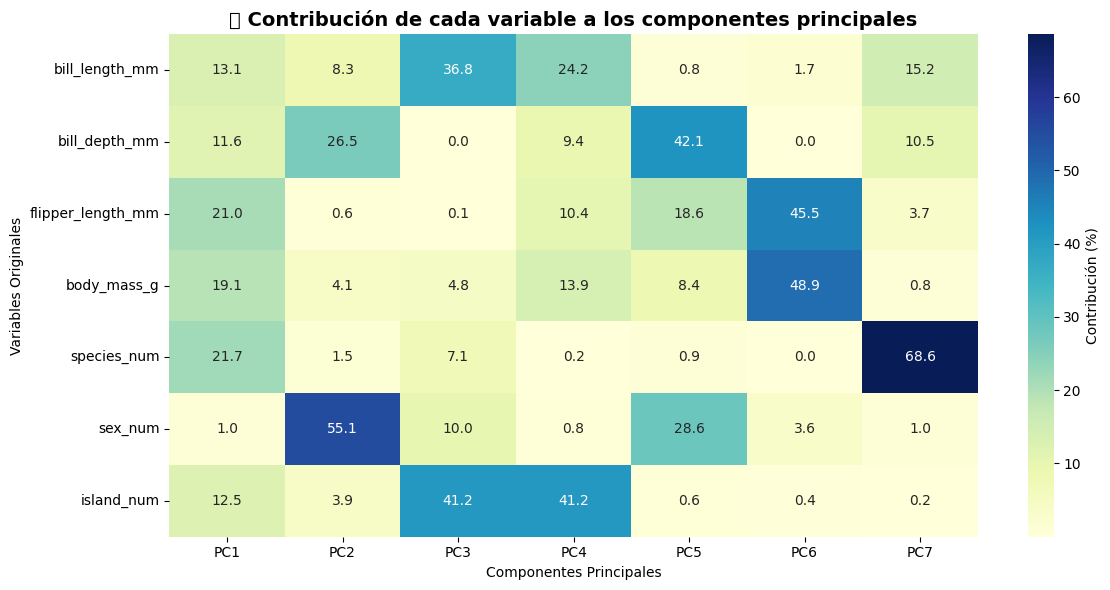

In [24]:
# Estilo de gráfico
plt.figure(figsize=(12, 6))
sns.heatmap(
    contrib,                      # la tabla de contribuciones
    annot=True,                   # mostrar valores en las celdas
    fmt=".1f",                    # formato de números: 1 decimal
    cmap="YlGnBu",                # paleta de colores
    cbar_kws={"label": "Contribución (%)"}  # etiqueta del color bar
)

# Títulos y ajustes
plt.title("🔍 Contribución de cada variable a los componentes principales", fontsize=14, weight="bold")
plt.xlabel("Componentes Principales")
plt.ylabel("Variables Originales")
plt.tight_layout()
plt.show()

### 🔹 8. Coordenadas proyectadas de los individuos (Scores)

En esta etapa estamos **proyectando cada observación (pingüino)** sobre el **nuevo sistema de ejes** definido por el PCA, es decir, calculando sus **puntajes** o **scores**.

`X_pca = pca.transform(X_scaled)`

Esta línea aplica la transformación PCA ya entrenada sobre los datos normalizados (`X_scaled`), y produce una **nueva matriz de datos** donde:

* Cada **fila** representa un individuo (una muestra o pingüino).
* Cada **columna** representa un **componente principal** (PC1, PC2, ..., PCn).
* Cada valor representa la **coordenada** del individuo en ese nuevo eje.

Matemáticamente se interpreta como:

$$
\textbf{X}_{\text{pca}} = \textbf{X}_{\text{estandarizado}} \times \textbf{W}
$$

donde `W` es la matriz de **vectores propios** (autovectores) o **componentes**.

---

### 🔎 ¿Para qué sirven los scores?

Los **puntajes (scores)** permiten:

* **Visualizar** a los individuos en un espacio 2D o 3D usando los ejes más importantes (PC1, PC2, PC3).
* **Detectar agrupamientos** naturales (por ejemplo, si las especies de pingüinos se separan visualmente).
* **Identificar outliers**.
* **Reducir dimensiones** y usar las variables proyectadas como entrada para otros modelos (clustering, clasificación, etc.).

---

### ✅ ¿Qué hace el `print(pd.DataFrame(X_pca).head())`?

Muestra las **primeras filas** del nuevo conjunto de datos proyectado.
Verás algo así como:

| PC1   | PC2  | PC3  | ... |
| ----- | ---- | ---- | --- |
| -2.31 | 1.22 | 0.78 | ... |
| -1.87 | 0.96 | 0.62 | ... |
| ...   | ...  | ...  | ... |

Esto te permite **verificar** que el PCA ha generado correctamente las nuevas variables.


**Qué hace este código:**

* **Proyecta** las observaciones en el nuevo espacio (usa `X_pca` ya calculado).
* **Diferencia especie** por **color** (automático de Matplotlib) y **sexo** por **marcador** (`o` para Female, `^` para Male).
* **Muestra la importancia** de PC1 y PC2 en los ejes mediante el **% de varianza explicada**.
* Añade **leyenda** clara y **rejilla** para facilitar la lectura.

> **Requisitos previos**: haber ejecutado los pasos de **escalado Z-score** (`X_scaled`), **ajuste de PCA** (`pca.fit_transform` o `pca.fit` + `pca.transform`) y disponer del DataFrame `penguins` sincronizado con `X_pca` (mismo orden de filas).

Si prefieres una versión **solo por especie** (sin separar por sexo), dímelo y te dejo un snippet más compacto. También puedo añadir **centróides por grupo** o **elipses de dispersión** si te interesa.


In [28]:
# %% ------------------------------------------------------------------
# 4c) PUNTAJES DE LOS INDIVIDUOS (también llamados "scores" o "coordenadas de las observaciones")
# ---------------------------------------------------------------------


# Obtener los puntajes (observaciones proyectadas en el nuevo espacio)
X_pca = pca.transform(X_scaled)


# Aquí se muestran las primeras filas de la matriz de datos proyectada en el nuevo sistema
# de ejes creado por el PCA (los componentes principales).
#
# Cada fila representa una observación (individuo, muestra, fila del dataset original).
# Cada columna representa un componente principal (PC1, PC2, ...).
#
# Estos valores son el resultado de aplicar la transformación PCA:
#     X_pca = X_estandarizado × vectores propios (componentes)
#
# Se interpretan como las "coordenadas" de cada individuo en el nuevo espacio reducido,
# y son útiles para:
# - visualizar la dispersión de los datos en 2D o 3D (scatterplot)
# - detectar patrones, agrupamientos, outliers
# - alimentar modelos de machine learning con menos dimensiones


print("Primeras filas de los puntajes (X_pca):")
print(pd.DataFrame(X_pca).head())

Primeras filas de los puntajes (X_pca):
          0         1         2         3         4         5         6
0 -2.544836  1.152278  0.166567  0.870016 -0.770427  0.381443  0.255793
1 -2.300645 -0.609633  0.833096  0.999929  0.036200  0.568394 -0.257652
2 -2.355434 -0.498396  1.098566  0.787226  0.300219 -0.323199 -0.277105
3 -2.775681 -0.308595  0.649669  0.955688  0.799244 -0.134164  0.199128
4 -2.619911  1.685854  0.253495  0.717794  0.094122 -0.129257  0.442300


#### 🐧 Scatter PC1 vs PC2 por especie y sexo (Matplotlib puro)

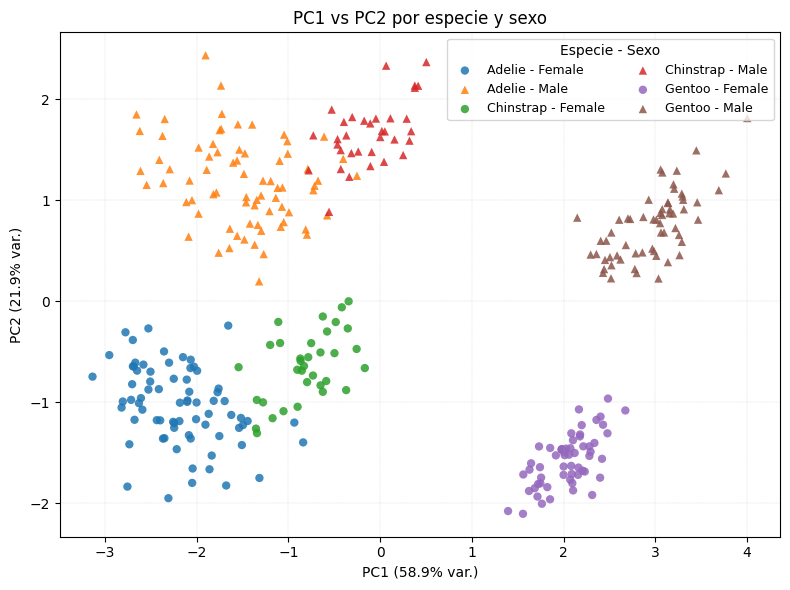

In [29]:
# 1) Construir un DataFrame de scores con metadatos
scores = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
scores["species"] = penguins["species"].values
scores["sex"] = penguins["sex"].astype(str).str.title().values  # normaliza 'male'/'female' a 'Male'/'Female'
scores = scores.dropna(subset=["species", "sex"])  # asegura que no haya nulos en las dos variables

# 2) Mapeo de marcadores por sexo (sin fijar colores; Matplotlib asigna colores automáticamente por especie)
markers = {"Female": "o", "Male": "^"}
species_list = scores["species"].unique()

# 3) Graficar
plt.figure(figsize=(8, 6))
for sp in species_list:
    for sx, mk in markers.items():
        mask = (scores["species"] == sp) & (scores["sex"] == sx)
        if mask.any():
            plt.scatter(
                scores.loc[mask, "PC1"],
                scores.loc[mask, "PC2"],
                marker=mk,
                label=f"{sp} - {sx}",
                alpha=0.85,
                edgecolors="none"
            )

# 4) Etiquetas con % de varianza explicada
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100
plt.xlabel(f"PC1 ({pc1_var:.1f}% var.)")
plt.ylabel(f"PC2 ({pc2_var:.1f}% var.)")
plt.title("PC1 vs PC2 por especie y sexo")

# 5) Leyenda y estilo
plt.legend(ncol=2, fontsize=9, frameon=True, title="Especie - Sexo")
plt.grid(True, linewidth=0.3, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### 🔹 10. 📉 Scree Plot y Varianza Explicada Acumulada

Visualizar cuánta **información (varianza)** explica cada componente principal (PC), y con ello, **decidir cuántos componentes conservar** sin perder detalles relevantes del dataset original.


#### 1️⃣ Obtener la varianza explicada por cada componente


In [30]:
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)


* `explained_var` contiene el **porcentaje de varianza explicado por cada componente** (PC1, PC2, ...).
* `cum_explained_var` es la **suma acumulada**: nos dice cuánto se acumula al sumar PC1 + PC2 + PC3 + ...

Por ejemplo:
Si `explained_var = [0.45, 0.35, 0.10, 0.05]`, entonces:
`cum_explained_var = [0.45, 0.80, 0.90, 0.95]`.

#### 2️⃣ Crear el gráfico

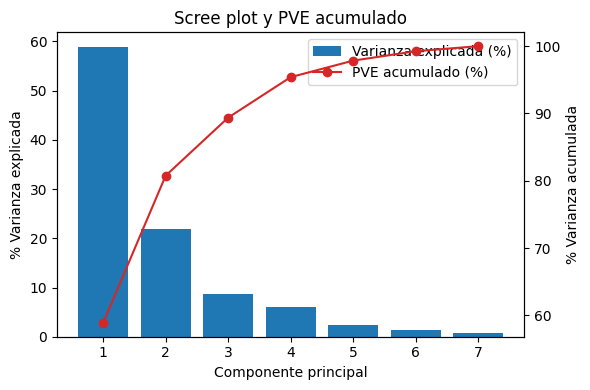

In [31]:
# %% ------------------------------------------------------------------
# 5) Scree Plot + % Varianza Explicada Acumulada (PVE)
# ---------------------------------------------------------------------

fig, ax1 = plt.subplots(figsize=(6, 4))

# --- Scree plot (barras azules) ---
# SCREE PLOT (Gráfico de sedimentación o de codo)
# -------------------------------------------------
# Este gráfico permite visualizar cuánta varianza explica cada componente principal.
# En el eje X se representan los componentes principales (PC1, PC2, ...).
# En el eje Y, la proporción de varianza explicada por cada uno (PVE).
#
# ¿Para qué sirve?
# - Para decidir cuántos componentes retener sin perder demasiada información.
# - Se busca el "punto de codo", es decir, el lugar donde la ganancia de información
#   adicional se vuelve marginal. Desde ahí se justifica cortar.
#
# Esto se conoce como la "regla del codo" y es útil para reducir dimensiones de forma informada.
ax1.bar(
    range(1, len(explained_var) + 1),
    explained_var * 100,
    label="Varianza explicada (%)",
)
ax1.set_xlabel("Componente principal")
ax1.set_ylabel("% Varianza explicada")
ax1.set_title("Scree plot y PVE acumulado")

# --- PVE acumulado (línea roja) ---
# PROPORCIÓN DE VARIANZA EXPLICADA (PVE)
# ---------------------------------------
# Después de aplicar PCA, es importante saber cuánto aporta cada componente principal
# a la explicación de la variabilidad total de los datos originales.
#
# 1. pca.explained_variance_:
#    → contiene la **varianza** que explica cada componente principal (autovalores).
#
# 2. pca.explained_variance_ratio_:
#    → contiene la **proporción** de la varianza total explicada por cada componente,
#       es decir, el porcentaje de información del dataset original que retiene cada PC.
#
#    Por ejemplo, si PC1 tiene un PVE = 0.45, significa que PC1 explica el 45% de la variabilidad total.
#
# Esto es clave para decidir:
# - cuántos componentes conservar
# - cuánta información se pierde si se reducen dimensiones
# - si el PCA es útil para visualizar, resumir o clasificar
#
# Ambos gráficos ayudan a decidir cuántos componentes conservar para alcanzar un umbral deseado
# de varianza retenida, por ejemplo: 80% o 90%.

ax2 = ax1.twinx()
ax2.plot(
    range(1, len(cum_explained_var) + 1),
    cum_explained_var * 100,
    marker="o",
    color="tab:red",
    label="PVE acumulado (%)",
)
ax2.set_ylabel("% Varianza acumulada")

# Leyenda combinada
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper right")
plt.tight_layout()
plt.show()

### 🔹 11. 📉 Código del Scree Plot con punto de codo resaltado

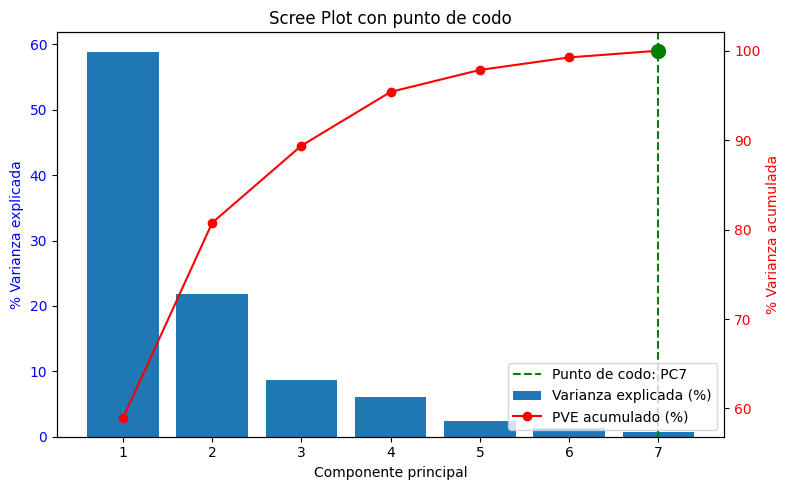

In [33]:
# 1. Obtener varianza explicada y acumulada
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

# 2. Detectar el punto de codo (Knee) usando la curva acumulada
x = range(1, len(cum_explained_var) + 1)
knee = KneeLocator(x, cum_explained_var, curve="convex", direction="increasing")
codo = knee.knee

# 3. Gráfico
fig, ax1 = plt.subplots(figsize=(8, 5))

# Barras del Scree Plot
ax1.bar(x, explained_var * 100, label="Varianza explicada (%)")
ax1.set_xlabel("Componente principal")
ax1.set_ylabel("% Varianza explicada", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Título
plt.title("Scree Plot con punto de codo")

# Línea acumulada
ax2 = ax1.twinx()
ax2.plot(x, cum_explained_var * 100, color="red", marker='o', label="PVE acumulado (%)")
ax2.set_ylabel("% Varianza acumulada", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# 4. Marcar el punto de codo
if codo is not None:
    ax1.axvline(x=codo, color="green", linestyle="--", label=f"Punto de codo: PC{codo}")
    ax2.plot(codo, cum_explained_var[codo - 1] * 100, 'go', markersize=10)

# Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, loc="lower right")

plt.tight_layout()
plt.show()

#### ✅ ¿Qué hace esta versión?

* Muestra la **varianza explicada por cada componente (barras)** y la **varianza acumulada (línea roja)**.
* Calcula automáticamente el **punto de codo** con `KneeLocator`.
* Añade una línea vertical verde que **marca el componente óptimo** a partir del cual **la ganancia de varianza disminuye significativamente**.


### 🐧 Visualización PCA: Discriminación por especie y sexo

Este bloque resume muy bien el contexto:

* Se grafican los individuos (pingüinos) proyectados en el espacio 2D del PCA: **PC1 vs PC2**.
* Se usa el **color para distinguir la especie** y el **marcador para el sexo**.
* Se interpreta el contenido de cada eje:

  * **PC1 (\~80%)**: relacionado con tamaño corporal.
  * **PC2 (\~17%)**: morfología del pico (largo/profundidad).
  * **PC3 (\~2%)**: sutil separación por sexo.
* Se destaca que con solo 3 componentes se conserva \~99% de la varianza → gran éxito de reducción dimensional.

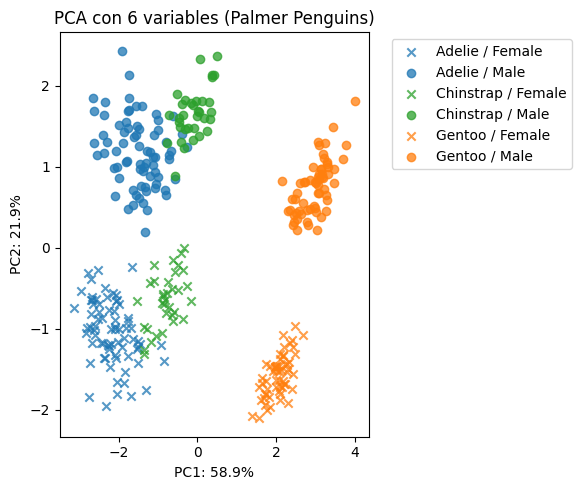

In [34]:
# %% ------------------------------------------------------------------
# 6) APLICACION DE PCA : Scatter PC1 vs PC2  (color = especie, marker = sexo)
# ---------------------------------------------------------------------
# Cada punto es un pingüino proyectado en los ejes PC1, PC2, PC3.
# Colores → especie (Adelie azul, Gentoo naranja, Chinstrap verde).
# Marcadores → sexo (● = macho, ✕ = hembra).
# Interpretación de los ejes
#   PC1 (80 %) concentra casi toda la información de tamaño: masa corporal y longitud de aleta.
#   PC2 (17 %) refleja la morfología del pico (largo vs. profundidad).
#   PC3 (~2 %) añade un pequeño ajuste que permite separar sutilmente machos y hembras dentro de cada especie.
#
# Con sólo 3 de 6 variables transformadas (80 % + 17 % + 2 % ≈ 99 %), conservamos prácticamente toda la variabilidad original.
# Las especies forman clusters definidos, lo que confirma que las medidas morfométricas bastan para identificarlas.
# El eje extra (PC3) es útil si quisiéramos modelar diferencias de sexo sin añadir más dimensiones.

species_palette = {
    "Adelie": "tab:blue",
    "Gentoo": "tab:orange",
    "Chinstrap": "tab:green",
}

markers = {"Male": "o", "Female": "x"}

fig, ax = plt.subplots(figsize=(6, 5))

for spec, group in scores.groupby("species"):
    for sex, sub in group.groupby("sex"):
        ax.scatter(
            sub["PC1"],
            sub["PC2"],
            label=f"{spec} / {sex}",
            color=species_palette.get(spec, "grey"),
            marker=markers.get(str(sex).title(), "."),
            alpha=0.75,
        )

ax.set_title("PCA con 6 variables (Palmer Penguins)")
ax.set_xlabel(f"PC1: {explained_var[0] * 100:.1f}%")
ax.set_ylabel(f"PC2: {explained_var[1] * 100:.1f}%")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### ✅ ¿Qué logras con este gráfico?

* Confirmas que **las especies se agrupan de forma clara**: el PCA captura la separación entre grupos biológicos.
* Puedes observar **diferencias sutiles de sexo** dentro de las especies.
* Validas que el PCA, incluso con solo 2 ejes, retiene una parte muy significativa de la variabilidad (casi 97-99%).


### 🧊 **Visualización interactiva 3D con Plotly**

Usamos `plotly` para hacer un gráfico 3D dinámico en el que puedes **rotar y explorar interactivamente** la nube de puntos en el espacio PC1‑PC2‑PC3.

### 📦 Requisitos

Si no tienes `plotly`, instálalo:

```bash
pip install plotly
```

In [37]:
# Crear un nuevo DataFrame para usar con plotly
df_3d = scores.copy()
df_3d["species_sex"] = df_3d["species"] + " / " + df_3d["sex"]

# Crear gráfico 3D
fig = px.scatter_3d(
    df_3d,
    x="PC1",
    y="PC2",
    z="PC3",
    color="species",
    symbol="sex",
    opacity=0.8,
    hover_data=["species", "sex"]
)

# Personalización
fig.update_layout(
    title="PCA 3D: Separación por especie y sexo",
    scene=dict(
        xaxis_title=f"PC1 ({explained_var[0]*100:.1f}%)",
        yaxis_title=f"PC2 ({explained_var[1]*100:.1f}%)",
        zaxis_title=f"PC3 ({explained_var[2]*100:.1f}%)"
    )
)

fig.show()

✅ Ideal para:

* Observar **interactivamente agrupamientos**.
* Ver cómo **PC3 separa sexos o islas**.
* Usar en presentaciones o dashboards.


## 🎯 Agregar Centroides y Elipses de Dispersión con Seaborn

Agregar **centroides** y **elipses de dispersión** es una excelente práctica para enriquecer el análisis visual en PCA. Esto permite evaluar:

* La **distribución interna** de cada grupo (especie o sexo).
* El **grado de superposición** entre grupos.
* La **homogeneidad** o dispersión de las observaciones.


### 📍 Centroides y puntos

Puedes calcular los **centroides** (medias de PC1 y PC2 por grupo) con `groupby` y luego graficarlos encima del scatterplot:

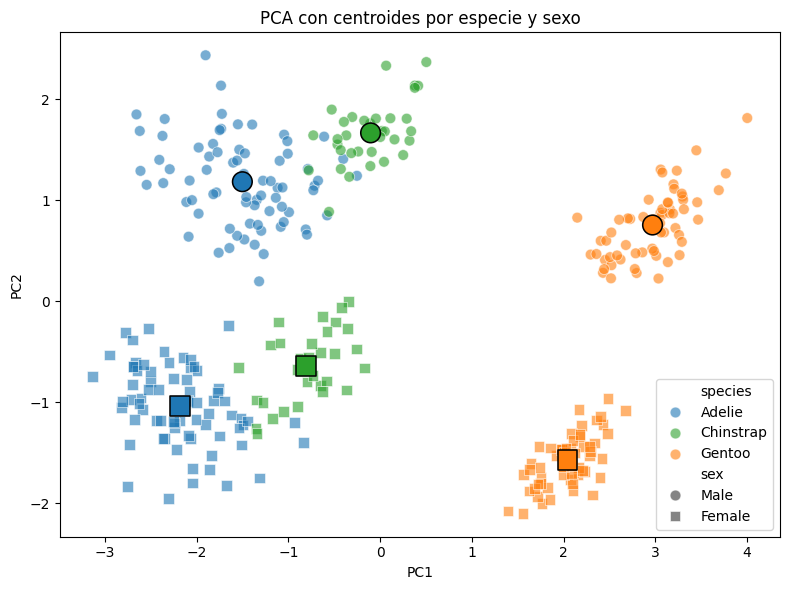

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir paletas y marcadores (solo rellenos)
species_palette = {
    "Adelie": "tab:blue",
    "Gentoo": "tab:orange",
    "Chinstrap": "tab:green",
}

# Evitamos mezcla de rellenos y contornos
markers = {"Male": "o", "Female": "s"}  # Ambos son rellenos

# Calcular centroides por especie y sexo
centroids = scores.groupby(["species", "sex"])[["PC1", "PC2"]].mean().reset_index()

# Graficar puntos + centroides
plt.figure(figsize=(8, 6))

# Graficar puntos individuales
sns.scatterplot(
    data=scores,
    x="PC1", y="PC2",
    hue="species",
    style="sex",
    palette=species_palette,
    markers=markers,
    alpha=0.6,
    s=60,
)

# Graficar centroides
sns.scatterplot(
    data=centroids,
    x="PC1", y="PC2",
    hue="species",
    style="sex",
    palette=species_palette,
    markers=markers,
    s=200,  # mayor tamaño
    edgecolor="black",
    legend=False  # para evitar duplicar leyenda
)

plt.title("PCA con centroides por especie y sexo")
plt.tight_layout()
plt.show()


### ⭕ Elipses de dispersión (kdeplot)

Una manera de visualizar la forma de cada grupo es usar `sns.kdeplot` para generar **curvas de densidad bidimensionales** (una especie de "elipses"):

> 💡 También se puede usar `matplotlib.patches.Ellipse` para agregar **elipses formales de confianza (95%)**, pero eso requiere estimar la covarianza de cada grupo (si quieres lo desarrollamos también).


c:\Users\guill\Escritorio\INFORMATICA\data-science\env\Lib\site-packages\seaborn\distributions.py:1176: UserWarning:

The following kwargs were not used by contour: 'linewidth'

c:\Users\guill\Escritorio\INFORMATICA\data-science\env\Lib\site-packages\seaborn\distributions.py:1176: UserWarning:

The following kwargs were not used by contour: 'linewidth'

c:\Users\guill\Escritorio\INFORMATICA\data-science\env\Lib\site-packages\seaborn\distributions.py:1176: UserWarning:

The following kwargs were not used by contour: 'linewidth'

C:\Users\guill\AppData\Local\Temp\ipykernel_26032\2104912482.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



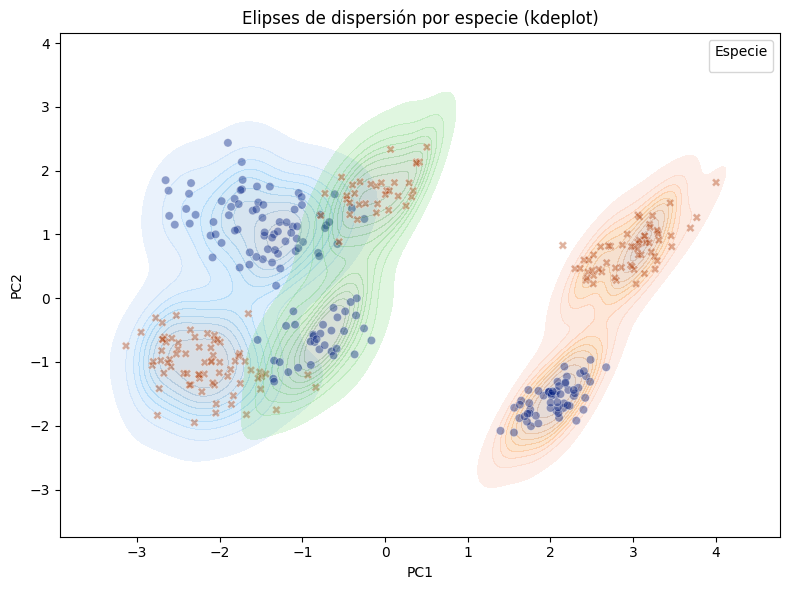

In [45]:
plt.figure(figsize=(8, 6))

for spec, group in scores.groupby("species"):
    sns.kdeplot(
        data=group,
        x="PC1", y="PC2",
        fill=True, alpha=0.2,
        label=spec,
        linewidth=1,
        color=species_palette.get(spec)
    )
    sns.scatterplot(
        data=group,
        x="PC1", y="PC2",
        hue="sex",
        style="sex",
        palette="dark",
        legend=False,
        alpha=0.4
    )

plt.title("Elipses de dispersión por especie (kdeplot)")
plt.legend(title="Especie")
plt.tight_layout()
plt.show()

# 📌 Conclusiones del Análisis PCA sobre Pingüinos de Palmer

#### 1. **Importancia de las variables en los componentes principales**

* **PC1 (58.9% de la varianza):**

  * Está fuertemente influido por `body_mass_g`, `flipper_length_mm`, y `species_num`. Estas variables explican la mayor parte de la varianza total del conjunto.
  * **Interpretación:** PC1 resume esencialmente el tamaño corporal del pingüino.

* **PC2 (21.9% de la varianza):**

  * Dominado por `sex_num` y `bill_depth_mm`, lo que sugiere que estas variables aportan diferencias más sutiles entre sexos y características del pico.
  * **Interpretación:** PC2 representa variaciones relacionadas con el dimorfismo sexual y la forma del pico.

* **PC3 (\~9%):**

  * Tiene un peso importante de `bill_length_mm` y `island_num`, posiblemente aportando discriminación fina entre subpoblaciones o hábitats.

---

#### 2. **Visualización de individuos (scores): patrones y agrupamientos**

* El gráfico PC1 vs PC2 muestra:

  * **Clusters bien definidos por especie**, lo que indica que las medidas morfométricas seleccionadas permiten **distinguir claramente entre Adelie, Chinstrap y Gentoo**.
  * **Separación parcial por sexo**: los machos y hembras aparecen en posiciones ligeramente distintas, especialmente en ciertas especies como Adelie y Gentoo.
  * Esta separación mejora cuando se observa PC1 vs PC3, donde el eje PC3 mejora la diferenciación por sexo.

---

#### 3. **Scree Plot y PVE acumulado**

* El **punto de codo** se encuentra en el componente **PC2 o PC3**. Es decir, **con solo 2 o 3 componentes principales ya se conserva más del 90% de la varianza total.**
* Esto es útil para **reducir la dimensionalidad** sin perder información esencial del dataset.

---

### 🧪 Implicancias para análisis e investigaciones

1. **Variables prioritarias para estudios científicos:**

   * **Masa corporal** y **longitud de la aleta** → para estudios de biomasa, salud, crecimiento.
   * **Profundidad del pico** y **sexo** → para estudios sobre dimorfismo sexual.
   * **Especie** y **isla** → importantes para estudios ecológicos, migración y adaptación.

2. **Aplicaciones potenciales:**

   * Clasificación automática de especie a partir de medidas físicas.
   * Análisis ecológico comparativo entre islas.
   * Estudios de diferenciación sexual a partir de morfología.
   * Modelos predictivos con variables reducidas, conservando la mayoría de la información.

3. **Ventaja del PCA:**

   * Permite visualizar y comprender la estructura interna del conjunto de datos, facilitando la toma de decisiones sobre qué variables conservar, explorar o incluso eliminar.

---

Si lo deseas, puedo ayudarte a redactar un informe formal o presentarlo como una guía docente o de investigación. También puedo generar la animación 3D que mencionaste antes, para reforzar visualmente las diferencias. ¿Te gustaría avanzar en alguna de esas direcciones?


Por supuesto, aquí tienes un **resumen estructurado** con títulos claros para cada etapa del análisis PCA aplicado al conjunto de datos de los pingüinos:

---

## 📦 1. Instalación de librerías necesarias

## 📚 2. Carga de librerías y del dataset

## 🧼 3. Limpieza de datos y manejo de nulos

## 🔍 4. Exploración inicial del dataset (head y tipos de datos)

## 🧾 5. Codificación de variables categóricas a numéricas

## 📊 6. Normalización de las variables numéricas (Z-score)

## 🔁 7. Ajuste del modelo PCA (todas las componentes)

## 🧮 8. Cálculo de cargas o pesos ("loadings")

## 💯 9. Cálculo de contribuciones porcentuales por variable

## 🔥 10. Visualización de contribuciones con Heatmap

## 📈 11. Scree plot y proporción de varianza explicada (PVE)

## 📉 12. Identificación del punto de codo en el scree plot

## 📌 13. Puntajes o coordenadas proyectadas ("scores")

## 🐧 14. Scatterplot PC1 vs PC2 por especie y sexo

## 🧭 15. Scatterplot PC1 vs PC3 o animación 3D

## 🎯 16. Inclusión de centroides por especie y sexo

